# Dissecting Spotify Valence

---

> *Practical Data Science*  <br />
> *MSc in Data Science, Department of Informatics*  <br />
> *Athens University of Economics and Business* <br />
> *Nakos Alexandros*


Spotify, a Swedish audio streaming and media services provider, was founded on April 23, 2006, by Daniel Ek and Martin Lorentzon. It stands as one of the largest music streaming service providers, boasting over 551 million monthly active users, including 220 million paying subscribers, as of June 2023.

Spotify uses a metric called *valence* to measure the happiness of a track. The metric itself, however, was not developed by Spotify. It was originally developed by Echo Nest, a company that was bought by Spotify in 2014. We don't know exactly how valence is calculated. Some details are given by a blog post, which you can find here:

https://web.archive.org/web/20170422195736/http://blog.echonest.com/post/66097438564/plotting-musics-emotional-valence-1950-2013

Our aim in this project is to untangle the mystery behind valence and examine how it is derived. For this purpose we will download tracks and their audio features using the Spotify Web API. The audio features contain track information such as acousticness, danceability, duration, energy, instrumentalness, valence and many more.

More details can be found here:
https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features

As a first step, You will use inferential statistic methods to study how track features influence valence. Then, based on the audio features, we will investigate whether we can successfully predict the valence of a song using machine learning.

## Introduction 

### *Libraries* 

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotnine import *

import glob
import re
from datetime import datetime
import itertools

import spotipy # Import the Spotipy library, a Python client for the Spotify Web API
from spotipy.oauth2 import SpotifyClientCredentials # Import a class for managing Spotify client credentials
from spotify_config import config

import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import shapiro

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

matplotlib.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

C:\Users\anakos\Anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
C:\Users\anakos\Anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
C:\Users\anakos\Anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


### *Data*

- First, we need to collect some data from *Spotify*
- Fortunately, *Spotify* has millions of playlists from which we can download tracks and audio features
- We will use the following public playlists available on the platform
    - The Longest Playlist on Spotify (Official)
    - The Longest Playlist Ever
    - Longest Playlist
    - Biggest Playlist Ever
    - Biggest Playlist On Spotify (10.000+ Hours!)
    - My Playlist: Rock, Metal, Rock n Roll

In [3]:
playlists = {'Top 10000 Songs Of All Time': ('Acclaimed Music', '1G8IpkZKobrIlXcVPoSIuf'),
                 'The Longest Playlist on Spotify (Official)': ('Willis Orr', '5S8SJdl1BDc0ugpkEvFsIL'),
                 'The Longest Playlist Ever': ('Oscar Lallier', '6yPiKpy7evrwvZodByKvM9'),
                 'Longest Playlist': ('Tuur Wondergem', '5TnAhglHWtvU09tVMUYMUI'),
                 'Biggest Playlist Ever': ('Susanna Ketola', '4rnleEAOdmFAbRcNCgZMpY'),
                 'Biggest Playlist On Spotify (10.000+ Hours!)': ('txcyr', '0z085jfTrSXxhFUyKKExxJ'),
                 'My Playlist: Rock, Metal, Rock n Roll': ('Jeremy Carver', '3WWv2APRYe9jR8L1YnK1Up')}

In [4]:
def get_audio_features(creator, playlist_id : dict
                       ,sp : spotipy.client.Spotify):
    """
    Function that returns a dataframe with the audio features given a playlist
    
    """
    
    # Define desired features
    playlist_features_list = ['song_id', 'song_name', 'artist',
                              'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key',
                              'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']
    
    # Create empty df
    playlist_df = pd.DataFrame(columns = playlist_features_list)
    
    # Download all playlist tracks    
    results = sp.user_playlist_tracks(creator, playlist_id)
    playlist = results['items']
    
    while results['next']:
        results = sp.next(results)
        playlist.extend(results['items'])
    
    # Loop through every track in the playlist
    for i, track in enumerate(playlist):
        
        if track['track'] is None:
            continue
        else:            
            # Create empty dict
            playlist_features = {}
            
            # Get song id
            if track['track']['id'] is None:
                continue
            else:
                playlist_features['song_id'] = track['track']['id']
                
            # Get song name
            if track['track']['name'] is None:
                continue
            else:
                playlist_features['song_name'] = track['track']['name']
                
            # Get artist
            if track['track']['artists'][0]['name'] is None:
                continue
            else:
                playlist_features['artist'] = track['track']['artists'][0]['name']
            
            # Get audio features 
            audio_features = sp.audio_features(playlist_features['song_id'])[0]
            if audio_features is None:
                continue
            else:
                for feature in playlist_features_list[3:16]:
                    playlist_features[feature] = audio_features[feature]
    
            # Create df to store audio features in each iteration
            track_df = pd.DataFrame(playlist_features, index = [0])
 
            # Concat dfs
            playlist_df = pd.concat([playlist_df, track_df], ignore_index = True)
    
    return playlist_df

def download_multiple_playlists(playlist_dict : dict
                                , sp : spotipy.client.Spotify):
    """
    Function that returns a dataframe with their audio features from a dictionary of playlists
    
    """
    
    # Loop through every playlist in the dictionary
    for i, (key, val) in enumerate(playlist_dict.items()):
        
        print(f'Downloading "{key}"...')
        
        # Call function to get audio features
        playlist_df = get_audio_features(*val, sp)
        
        # Store the playlist name
        playlist_df['playlist'] = key
        
        # Create df to store info
        if i == 0:
            playlist_dict_df = playlist_df
        else:
            playlist_dict_df = pd.concat([playlist_dict_df, playlist_df], ignore_index = True)
            
        print(f'Downloading "{key}"... Done!', end='\n\n')
            
    return playlist_dict_df

def get_audio_features_with_ids(track_ids : list
                                , sp : spotipy.client.Spotify):
    """
    Function that returns a dataframe of the audio features for every track given a list of track IDs
    
    """
    
    # Define desired features
    playlist_features_list = ['song_id',
                              'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key',
                              'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']
    
    # Create empty df
    playlist_df = pd.DataFrame(columns = playlist_features_list)
    
    print('Getting audio features...')
    
    # Loop through every track id in the list
    for i, track_id in enumerate(track_ids):
        
        if track_id is None:
            continue
        else:            
            # Create empty dict
            playlist_features = {}
            
            # Store track ID
            playlist_features['song_id'] = track_id
            
            # Get audio features 
            audio_features = sp.audio_features(track_id)[0]
            if audio_features is None:
                continue
            else:
                for feature in playlist_features_list[1:14]:
                    playlist_features[feature] = audio_features[feature]
    
            # Create df to store audio features in each iteration
            features_df = pd.DataFrame(playlist_features, index = [0])
            
            # Concat dfs
            playlist_df = pd.concat([playlist_df, features_df], ignore_index = True)
            
    print('Getting audio features... Done!', end='\n\n')

    return playlist_df

In [5]:
# Import necessary modules and libraries
from spotify_config import config  # Import a configuration file holding the username and password

# Create a SpotifyClientCredentials object
client_credentials_manager = SpotifyClientCredentials(
    config['client_id'],  # Use the client_id from the imported config
    config['client_secret']  # Use the client_secret from the imported config
)

# Create a Spotify object (sp) by passing the client_credentials_manager
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [ ]:
# download tracks and their audio features
spotify = download_multiple_playlists(playlists,sp)

# drop duplicate ids
spotify.drop_duplicates(subset=['song_id'], inplace=True, ignore_index=True)

# save raw spotify data
spotify.to_csv('./data/spotify_playlists_data.csv', index=False)

#drop from memory
del spotify

- We have already downloaded and saved the audio features in a scv file
- Therefore we will load the data directly from the file
- For reference the download procedure takes approximately 2 hours, because Spotify imposes a rate limit 

In [7]:
file_path = 'data/spotify_playlists_data.csv'

spotify_df = pd.read_csv(file_path)

##### *Descriptive Statistics*

In [6]:
spotify_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49662 entries, 0 to 49661
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_id           49662 non-null  object 
 1   song_name         49658 non-null  object 
 2   artist            49658 non-null  object 
 3   acousticness      49662 non-null  float64
 4   danceability      49662 non-null  float64
 5   duration_ms       49662 non-null  int64  
 6   energy            49662 non-null  float64
 7   instrumentalness  49662 non-null  float64
 8   key               49662 non-null  int64  
 9   liveness          49662 non-null  float64
 10  loudness          49662 non-null  float64
 11  mode              49662 non-null  int64  
 12  speechiness       49662 non-null  float64
 13  tempo             49662 non-null  float64
 14  time_signature    49662 non-null  int64  
 15  valence           49662 non-null  float64
 16  playlist          49662 non-null  object

In [7]:
spotify_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
acousticness,49662.0,0.220845,0.288522,0.0,0.00598,0.073200,0.3480,0.996
danceability,49662.0,0.557983,0.175249,0.0,0.44000,0.564000,0.6860,0.988
duration_ms,49662.0,245681.412790,187151.925920,5307.0,189146.25000,222093.000000,265133.0000,6000661.000
energy,49662.0,0.675019,0.228865,0.0,0.52400,0.712000,0.8650,1.000
instrumentalness,49662.0,0.097015,0.235634,0.0,0.00000,0.000055,0.0142,0.999
key,49662.0,5.257883,3.577308,0.0,2.00000,5.000000,8.0000,11.000
liveness,49662.0,0.211181,0.188294,0.0,0.09710,0.133000,0.2700,0.999
loudness,49662.0,-7.552265,3.955556,-60.0,-9.20000,-6.574000,-4.9040,1.634
mode,49662.0,0.637993,0.480586,0.0,0.00000,1.000000,1.0000,1.000
speechiness,49662.0,0.087014,0.093312,0.0,0.03610,0.051300,0.0938,0.963


##### *Change the track duration time unit from miliseconds to seconds*

In [8]:
#create a copy so we do not change the initial df
Audio_df = spotify_df.copy()

#unit conversion
Audio_df['duration_ms'] = Audio_df['duration_ms'] / 1000

# rename column
Audio_df = Audio_df.rename(columns={'duration_ms':'duration_sec'})

##### *Fix time signature (valid values in [4,7])*

In [9]:
#check if there are invalid time signatures
Audio_df.time_signature.value_counts()

4    45978
3     2794
5      561
1      279
0       50
Name: time_signature, dtype: int64

In [10]:
# Create a list of indexes to drop
indexes_to_drop = list(Audio_df[Audio_df['time_signature'].apply(lambda x: x not in range(3, 8))].index)

# Use the drop method to remove the rows with the specified indexes
Audio_df.drop(indexes_to_drop, inplace=True)

Audio_df.shape

(49333, 17)

In [11]:
Audio_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
acousticness,49333.0,0.219093,0.287012,0.00000,0.00593,0.072500,0.3430,0.996
danceability,49333.0,0.559308,0.174168,0.05850,0.44100,0.565000,0.6860,0.988
duration_sec,49333.0,244.836081,175.623960,15.13300,189.30700,222.200000,265.1540,6000.295
energy,49333.0,0.676594,0.227560,0.00002,0.52600,0.714000,0.8660,1.000
instrumentalness,49333.0,0.096060,0.234184,0.00000,0.00000,0.000055,0.0139,0.999
key,49333.0,5.258792,3.577061,0.00000,2.00000,5.000000,8.0000,11.000
liveness,49333.0,0.210953,0.187952,0.00829,0.09710,0.133000,0.2700,0.999
loudness,49333.0,-7.510251,3.851932,-60.00000,-9.16400,-6.560000,-4.8980,1.634
mode,49333.0,0.637748,0.480656,0.00000,0.00000,1.000000,1.0000,1.000
speechiness,49333.0,0.086893,0.092648,0.02230,0.03610,0.051300,0.0937,0.963


## Expore which Track Features Influence Valence

- We will use inferential statistic methods to study how track features influence valence.
- We will find the best possible model for explaining the valence based on the features we find significant.

#### *Pairwise Feature Correlation*

Pairwise feature correlation, is a statistical technique to measure and understand the relationships between pairs of features (variables or attributes) in a dataset. It involves calculating correlation coefficients to determine how closely related two features are and whether they exhibit similar or opposite behaviors.

#### *Calculate and plot pairwise feature correlation heatmap*

We will use the Pearson correlation coefficient (Pearson's r). This coefficient ranges from -1 to 1, with the following interpretations:

- A value of 1 indicates a perfect positive linear correlation (as one feature increases, the other also increases).
- A value of -1 indicates a perfect negative linear correlation (as one feature increases, the other decreases).
- A value near 0 indicates little to no linear correlation.

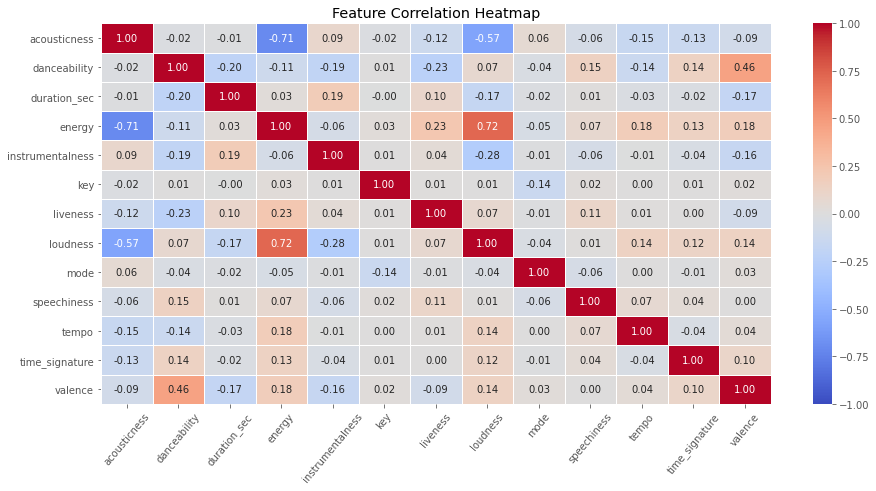

In [12]:
# calculate correlation
corr = Audio_df.corr(method='pearson')

# create figure
plt.figure(figsize=(15,7))

# plot heatmap
sns.heatmap(corr, annot=True, fmt='.2f', vmin=-1, cmap=sns.color_palette("coolwarm", as_cmap=True), linewidths=1.0)

# set title and x axis labels rotation
plt.xticks(rotation=50)
plt.title('Feature Correlation Heatmap')

plt.show()

- As we can see the following pairs are strongly linearly correlated features
    - **acousticness** - **energy** have a strong **negative** linear correlation
    - **energy** - **loudness** have a strong **positive** linear correlation

### *Feature Importance*

- In order to find which features are important we will use regression. 
- We will assess the various models based on the adjusted $R^2$.
- Some of our data features are nominal, and thus we will convert them to dummy before proceeding with the regression

In [13]:
#copy of df
Feat_df = Audio_df.copy()

# create dummy variables for nominal features
Feat_df = pd.get_dummies(Feat_df, columns=['key', 'mode', 'time_signature'], drop_first=True)

##### *Linear Regression Model*

In [14]:
# define equation
eq = 'valence ~ ' + '+'.join(Feat_df.drop(columns=['song_id', 'song_name', 'artist', 'valence', 'playlist']))

# create and fit linear regression model
model = smf.ols(eq, data = Feat_df).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     1021.
Date:                Thu, 12 Oct 2023   Prob (F-statistic):               0.00
Time:                        15:59:05   Log-Likelihood:                 9491.4
No. Observations:               49333   AIC:                        -1.893e+04
Df Residuals:                   49309   BIC:                        -1.872e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.4783      0.010    -45.794      0.000      -0.499      -0.458
acousticness         0.1370      0.005     30.318      0.000       0.128       0.146
danceability         0.7274      0.006    123.703      0.000       0.716       0.739
duration_sec        -0.0001   5.43e-06    -23.153      0.000      -0.000      -0.000
energy               0.5462      0.007     74.721      0.000       0.532       0.561
instrumentalness    -0.0966      0.004    -23.226      0.000      -0.105      -0.088
liveness            -0.0306      0.005     -5.986      0.000      -0.041      -0.021
loudness            -0.0143      0.000    -38.008      0.000      -0.015      -0.014
speechiness         -0.2664      0.010    -26.203      0.000      -0.286      -0.246
tempo                0.0007   3.25e-05     21.453      0.000       0.001       0.001
key_1               -0.0305      0.004     -7.850      0.000      -0.038      -0.023
key_2               -0.0128      0.004     -3.306      0.001      -0.020      -0.005
key_3                0.0041      0.006      0.699      0.485      -0.007       0.016
key_4               -0.0075      0.004     -1.795      0.073      -0.016       0.001
key_5                0.0107      0.004      2.552      0.011       0.002       0.019
key_6               -0.0021      0.004     -0.481      0.630      -0.011       0.006
key_7                0.0039      0.004      1.017      0.309      -0.004       0.011
key_8               -0.0144      0.004     -3.312      0.001      -0.023      -0.006
key_9                0.0082      0.004      2.123      0.034       0.001       0.016
key_10              -0.0044      0.005     -0.956      0.339      -0.013       0.005
key_11              -0.0016      0.004     -0.380      0.704      -0.010       0.007
mode_1               0.0241      0.002     12.387      0.000       0.020       0.028
time_signature_4     0.0123      0.004      3.040      0.002       0.004       0.020
time_signature_5     0.0314      0.009      3.389      0.001       0.013       0.050
==============================================================================
Omnibus:                      445.035   Durbin-Watson:                   1.673
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              303.429
Skew:                           0.060   Prob(JB):                     1.29e-66
Kurtosis:                       2.635   Cond. No.                     4.52e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### *Statistically significant features*

- We will evaluate the significance of each feature at a 0.05 significance level.
- All p-values below or equal to 0.05 indicate statistical significance, because it leads us to reject the null hypothesis that states that the feature in question is not equal to zero
- The features that meet the criterion above are shown below

In [15]:
#define statistically significant features
[model.pvalues.index[i] for i in range(len(model.pvalues)) if model.pvalues[i] <= 0.05 and i != 0]

['acousticness',
 'danceability',
 'duration_sec',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'key_1',
 'key_2',
 'key_5',
 'key_8',
 'key_9',
 'mode_1',
 'time_signature_4',
 'time_signature_5']

##### *Model Improvement*

- In order to improve our initial model will introduce some non-linear features in the model
- The non-linear features will be the following initial features raised to the power of two
    - acousticness
    - duration_sec
    - tempo
    - instrumentalness
    - speechiness

In [16]:
# define equation
eq_v2 = (
    'valence ~ ' + '+'.join(Feat_df.drop(columns=['song_id', 'song_name', 'artist', 'valence', 'playlist'])).strip() + 
    ' + np.power(acousticness, 2) + np.power(duration_sec, 2) + np.power(tempo, 2) \
     + np.power(instrumentalness, 2) + np.power(speechiness, 2)'
)

# create and fit model
model_v2 = smf.ols(eq_v2, data = Feat_df).fit()

model_v2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     923.5
Date:                Thu, 12 Oct 2023   Prob (F-statistic):               0.00
Time:                        15:59:09   Log-Likelihood:                 10281.
No. Observations:               49333   AIC:                        -2.050e+04
Df Residuals:                   49304   BIC:                        -2.025e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.0964      0.016     -5.901      0.000      -0.128      -0.064
acousticness                      0.2707      0.012     23.490      0.000       0.248       0.293
danceability                      0.7513      0.006    119.203      0.000       0.739       0.764
duration_sec                     -0.0003   1.07e-05    -27.711      0.000      -0.000      -0.000
energy                            0.5768      0.007     79.563      0.000       0.563       0.591
instrumentalness                 -0.1572      0.016     -9.634      0.000      -0.189      -0.125
liveness                         -0.0190      0.005     -3.765      0.000      -0.029      -0.009
loudness                         -0.0150      0.000    -40.055      0.000      -0.016      -0.014
speechiness                      -0.6760      0.022    -30.753      0.000      -0.719      -0.633
tempo                            -0.0055      0.000    -23.039      0.000      -0.006      -0.005
key_1                            -0.0290      0.004     -7.563      0.000      -0.036      -0.021
key_2                            -0.0110      0.004     -2.898      0.004      -0.018      -0.004
key_3                             0.0054      0.006      0.934      0.350      -0.006       0.017
key_4                            -0.0069      0.004     -1.686      0.092      -0.015       0.001
key_5                             0.0104      0.004      2.525      0.012       0.002       0.019
key_6                            -0.0008      0.004     -0.184      0.854      -0.009       0.008
key_7                             0.0046      0.004      1.231      0.218      -0.003       0.012
key_8                            -0.0121      0.004     -2.823      0.005      -0.020      -0.004
key_9                             0.0092      0.004      2.398      0.016       0.002       0.017
key_10                           -0.0040      0.005     -0.878      0.380      -0.013       0.005
key_11                        -7.097e-05      0.004     -0.017      0.986      -0.008       0.008
mode_1                            0.0214      0.002     11.181      0.000       0.018       0.025
time_signature_4                  0.0164      0.004      4.086      0.000       0.009       0.024
time_signature_5                  0.0350      0.009      3.828      0.000       0.017       0.053
np.power(acousticness, 2)        -0.1813      0.013    -13.717      0.000      -0.207      -0.155
np.power(duration_sec, 2)      4.989e-08   2.71e-09     18.433      0.000    4.46e-08    5.52e-08
np.power(tempo, 2)             2.444e-05    9.3e-07     26.280      0.000    2.26e-05    2.63e-05
np.power(instrumentalness, 2)     0.0952      0.020      4.779      0.000       0.056       0.134
np.power(speechiness, 2)          0.6879     

##### *Results Validation*
- As we can see the value $R^2$ is now equal to 0.344 , which is an improvement over the previous model (0.323).  
- We also note that all the added predictors are statistically significant in all levels with p-values almost equal to zero.
- In order to further validate that the non-linear model is a better fit than the original we are going to use ANOVA.
- As we can see from below we get a p-value which is almost zero, leading us to reject the null hypothesis that both models fit the data equally well.

In [17]:
table = sm.stats.anova_lm(model, model_v2)
table

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,49309.0,1965.851362,0.0,NaN,NaN,NaN
1,49304.0,1903.887101,5.0,61.96426,320.931414,0.0


- Next we have the Q-Q plot and we can see that we have some deviation from normality which is present in the edges.

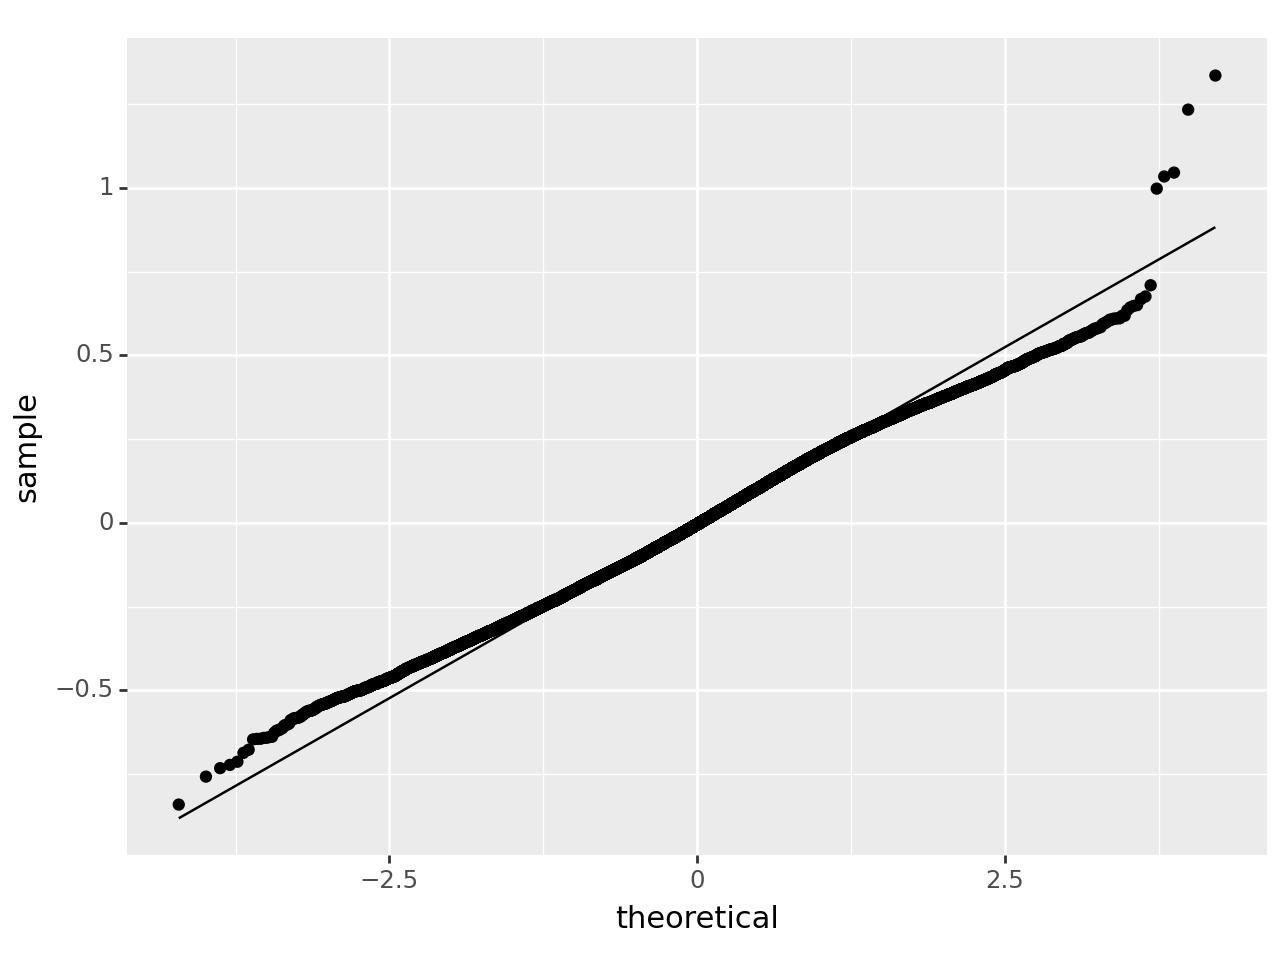

<Figure Size: (640 x 480)>

In [18]:
ggplot(data=model_v2.resid.to_frame().rename(columns={0: 'resid'})) +\
    geom_qq(mapping=aes(sample='resid')) +\
    geom_qq_line(mapping=aes(sample='resid'))

- In the residuals plot that follows we can see no obvious patern in the distribution and as a result we can assume normality. 

<Axes: xlabel='valence'>

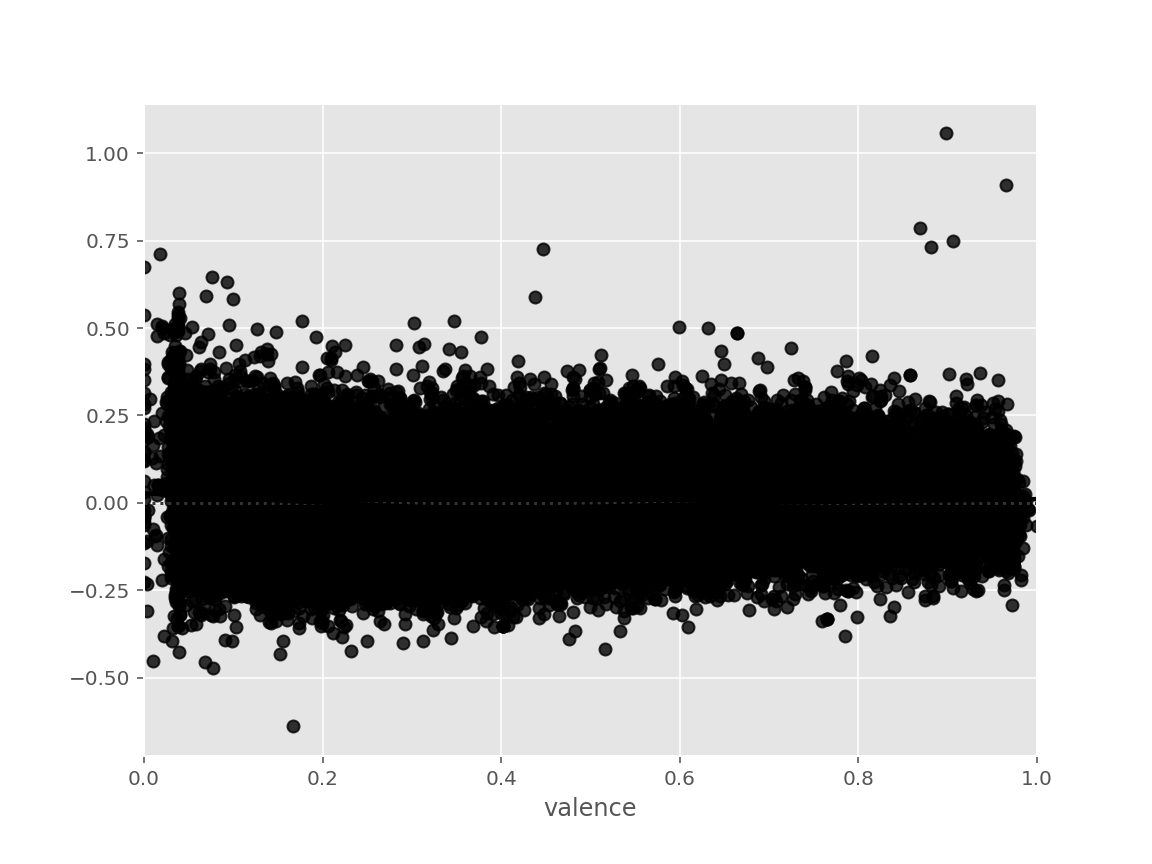

In [19]:
plt.figure(figsize=(8, 6))
sns.residplot(x=Feat_df.valence, y=model_v2.resid, lowess=True, color="black")

## *Predict Valence*

In [20]:
#dataframe copy
ml_df = Audio_df.copy()

##### *One-Hot Encoding*

In [21]:
# get dummy variables
ml_df = pd.get_dummies(ml_df, columns=['key', 'mode', 'time_signature'], drop_first=False)

# drop unwanted columns
ml_df = ml_df.drop(columns=['song_id', 'song_name', 'artist', 'playlist'])

##### *Song Duration*

- We can see that the duration feature exhibits a large variation
- To deal with that we will assume that valid songs are the ones that have a duration higher than 1 minute and lower than the 99% quantile (aprox. 11 mins)

In [22]:
#descriptive statistics
print(ml_df.duration_sec.describe())

#variance
print(f'\n Song Duration Variance: {ml_df.duration_sec.var()}')

#99% quantile
q = np.percentile(ml_df.duration_sec, 99)
print(f'\n Song Duration 99% Quantile: {q} sec')

count    49333.000000
mean       244.836081
std        175.623960
min         15.133000
25%        189.307000
50%        222.200000
75%        265.154000
max       6000.295000
Name: duration_sec, dtype: float64

 Song Duration Variance: 30843.775394667813

 Song Duration 99% Quantile: 654.5200000000003 sec


In [23]:
#keep valid songs
ml_df = ml_df[(ml_df.duration_sec > 60) & (ml_df.duration_sec < q)]

# shape
ml_df.shape

(48608, 27)

#### *Train Test Split* 

In [24]:
# define features and target variable
x = ml_df.drop(columns='valence')
y = ml_df.valence

# train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

##### *Feature Scaling*

- First we obtain the features that need scaling
- Then we define the scaling method as follows:
    - We check whether each feature follows a normal distribution, by performing the Shapiro-Wilk normality test
    - If it is we will use the standard scaler
    - If not we will use the min - max scales

In [25]:
#define features to be checked
feat = [feature for feature in x_train.columns if (ml_df[feature].max() > 1)]

#print features
print(feat)

['duration_sec', 'loudness', 'tempo']


In [26]:


def check_normality(df):
    """
    Check if each feature in a DataFrame follows a normal distribution.

    Parameters:
    df (DataFrame): The input DataFrame.

    Returns:
    normality_results (DataFrame): A DataFrame summarizing the normality test results.
    """
    # Create an empty DataFrame to store results
    normality_results = pd.DataFrame(columns=['Feature', 'Is_Normal', 'p-value'])

    # Iterate over each column (feature) in the DataFrame
    for column in df.columns:
        data = df[column].dropna()  # Remove missing values
        
        # Perform the Shapiro-Wilk normality test
        _, p_value = stats.shapiro(data)
        
        # Set a significance level (e.g., 0.05)
        alpha = 0.05
        
        # Check if the feature follows a normal distribution
        is_normal = p_value > alpha
        
        # Append the results to the DataFrame
        normality_results = normality_results.append({'Feature': column, 'Is_Normal': is_normal, 'p-value': p_value}, ignore_index=True)

        # Create a Q-Q plot for the feature
        
        plt.figure(figsize=(10, 6))
        stats.probplot(data, dist="norm", plot=plt)
        plt.title(f'Q-Q Plot for {column}')
        plt.show()

    return normality_results

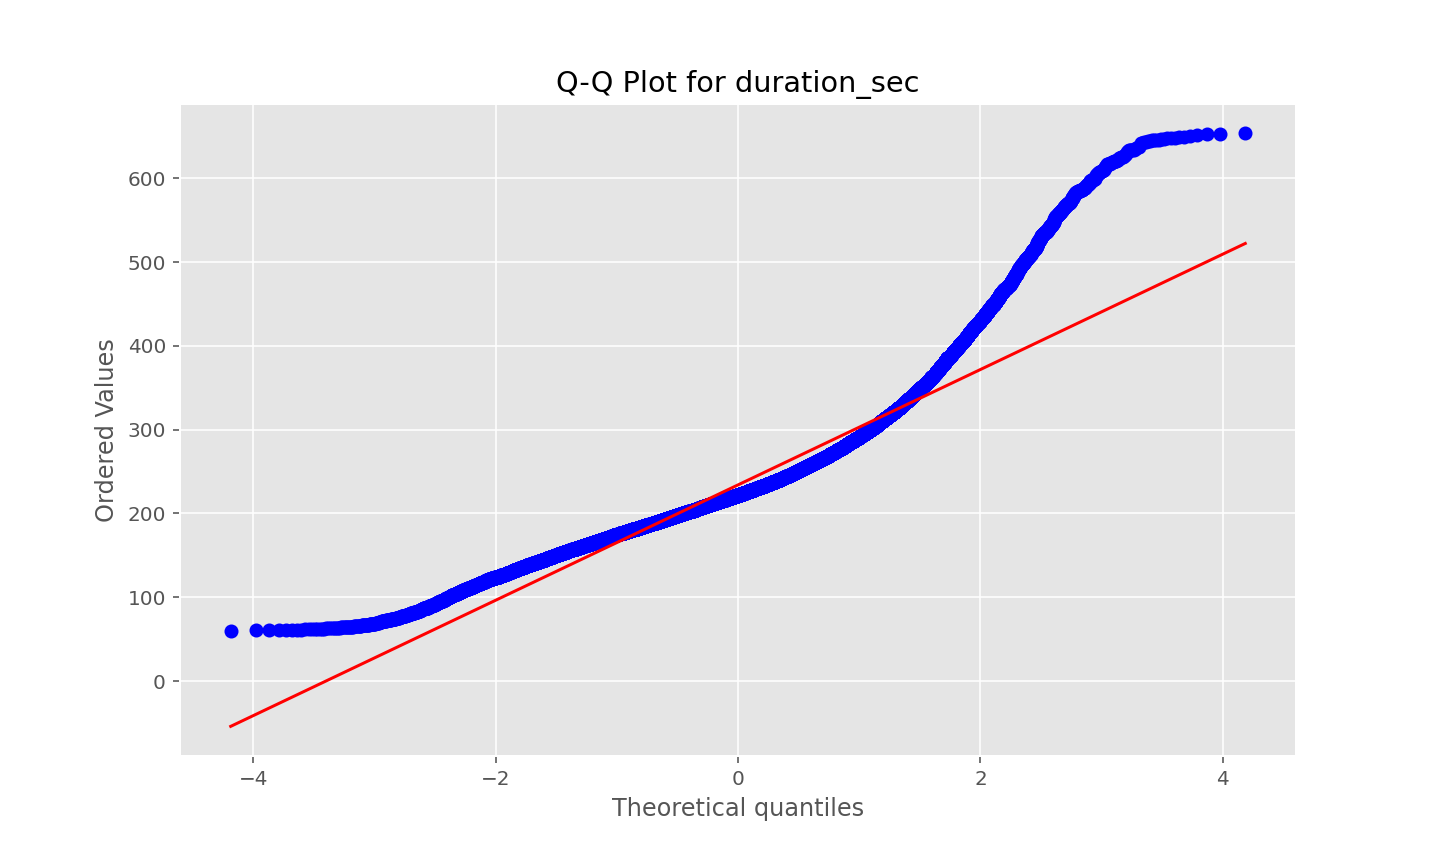

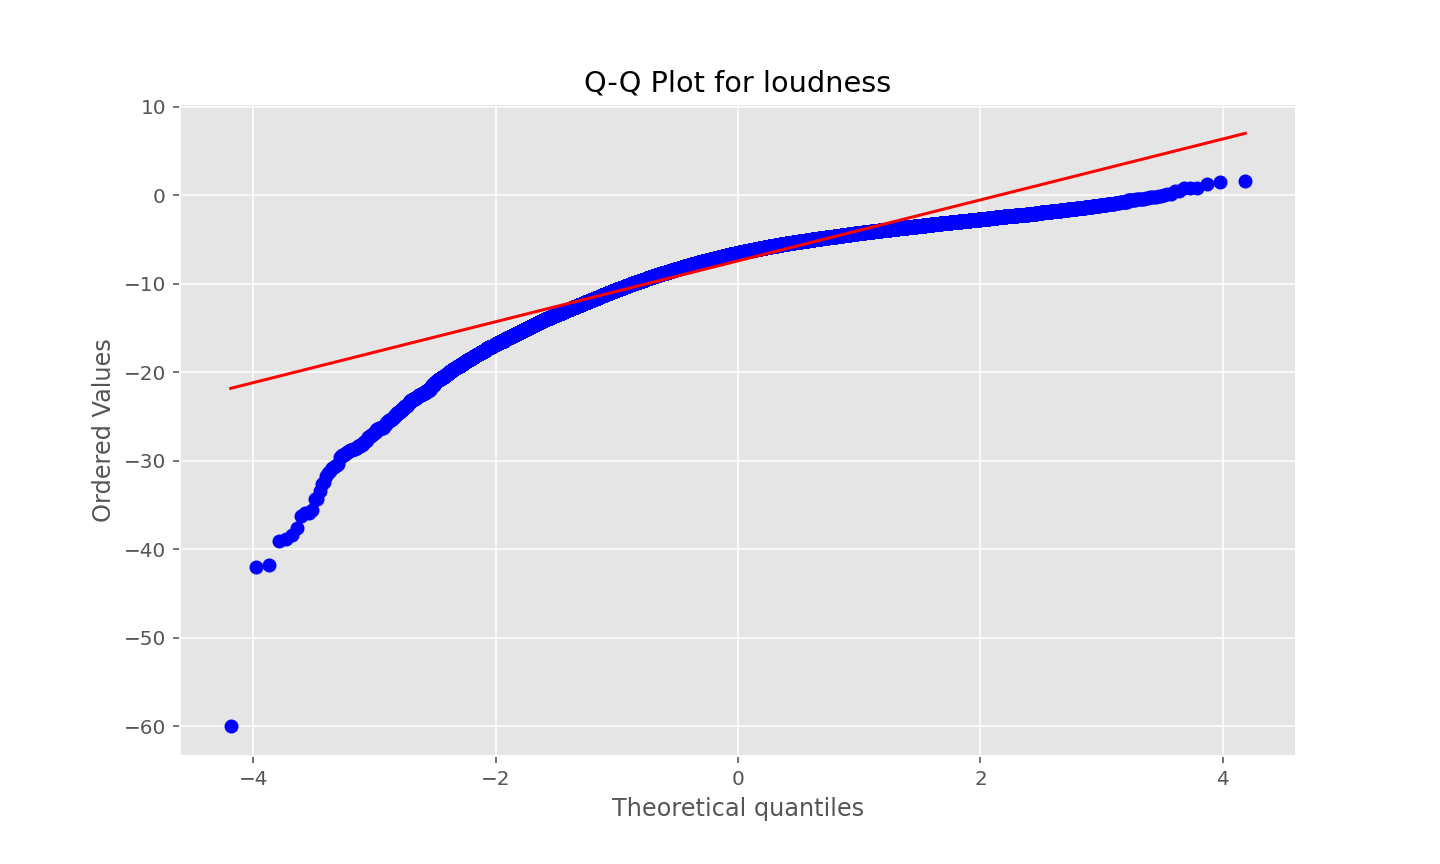

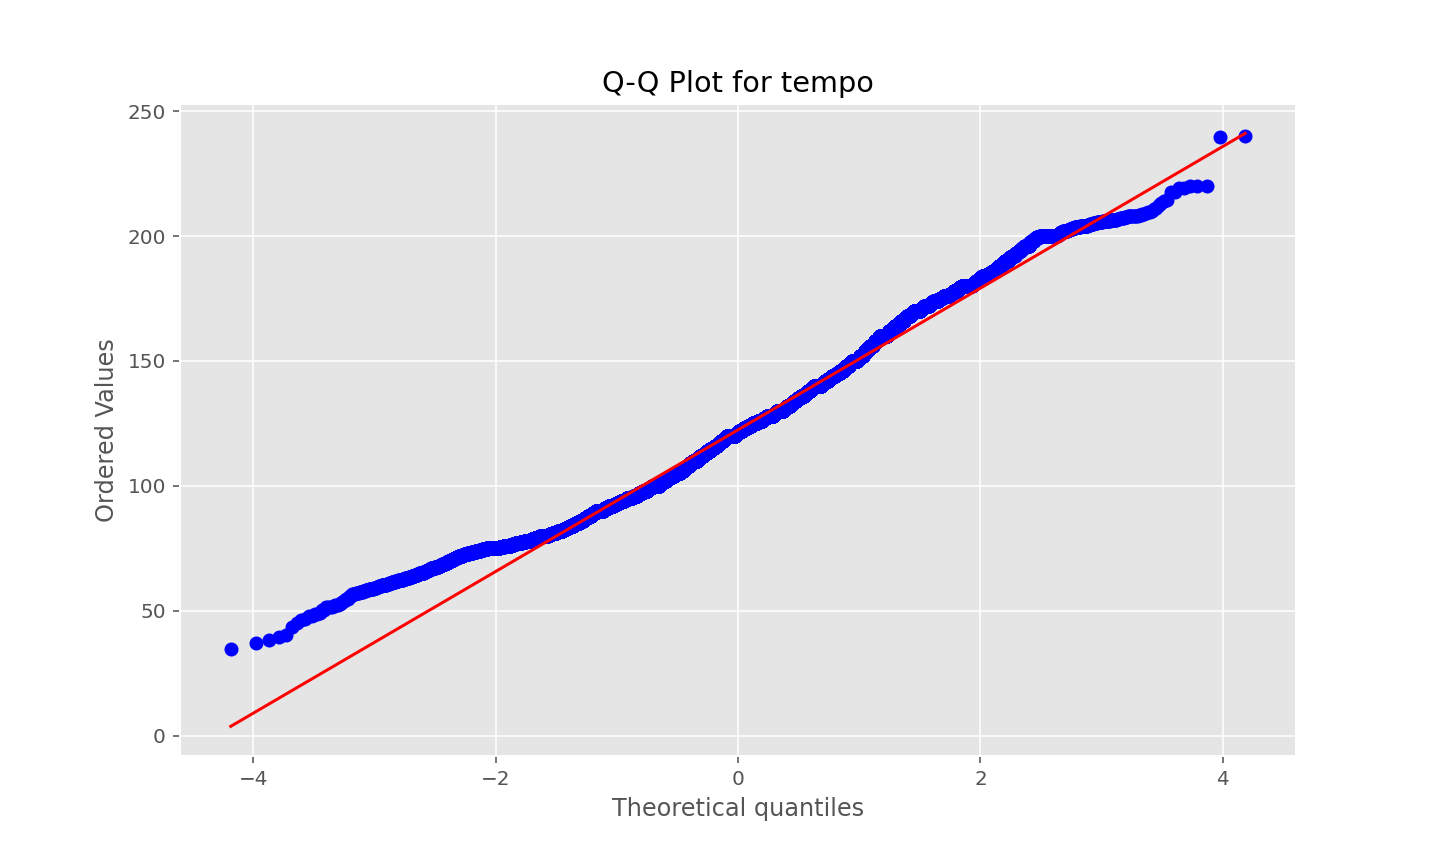

,Feature,Is_Normal,p-value
0,duration_sec,False,0.0
1,loudness,False,0.0
2,tempo,False,0.0


In [27]:
check_normality(ml_df.loc[: ,feat])

##### *Scale using MinMaxScaler*

- None of our features follows a normal ditribution therefore we will use the minmax scaler

In [28]:
# initialise scaler
scaler = MinMaxScaler()

# apply scaler to the features
x_train[feat] = scaler.fit_transform(x_train[feat])
x_test[feat] = scaler.transform(x_test[feat])

## Modeling

#### *Regressor Evaluation Function* 

In [206]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

def evaluate_regressors(regressors, X_train, y_train, splits):
    """
    Evaluate multiple classifiers using K-fold cross-validation and return evaluation metrics.

    Parameters:
    classifiers (dict): A dictionary of classifier names as keys and classifier instances as values.
    X_train (pd.DataFrame or np.array): The training features.
    y_train (pd.Series or np.array): The training labels.

    Returns:
    results_df (pd.DataFrame): A DataFrame with classifier names and their evaluation metrics.
    """
    results = []

    # Define 5-fold cross-validation
    kf = KFold(n_splits=splits, shuffle=True, random_state=42)

    for regressor_name, regressor in regressors.items():
        # Perform cross-validation and make predictions
        y_pred = cross_val_predict(regressor, X_train, y_train, cv=kf, n_jobs = 10)

        # Calculate evaluation metrics
        mae = mean_absolute_error(y_train, y_pred)
        mse = mean_squared_error(y_train, y_pred)
        rmse = sqrt(mse)

        # Append results to the list
        results.append({'Regressor': regressor_name, 'MAE': mae, 'MSE': mse, 'RMSE': rmse})

    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)

    return results_df

In [49]:
regressors = {
    'SVR': SVR(),
    'ExtraTrees' : ExtraTreesRegressor(random_state=123),
    'RandomForest': RandomForestRegressor(random_state=123),
    'XGBoost': XGBRegressor(random_state=123),
    'LightGBM': LGBMRegressor(random_state=123),
 }

# set starting time
start_time = datetime.now()

# Execute function
results_df = evaluate_regressors(regressors, x_train, y_train, 5)

# set ending time
end_time = datetime.now()

#print elapsed time
print(f'Elapsed time: {end_time - start_time}')

Elapsed time: 0:02:44.682906


In [23]:
# print results
print(results_df.sort_values(by='MAE'))

     Classifier       MAE       MSE      RMSE
1    ExtraTrees  0.134366  0.030361  0.174244
2  RandomForest  0.137348  0.030474  0.174568
3       XGBoost  0.143200  0.032391  0.179974
4      LightGBM  0.143364  0.031899  0.178604
0           SVR  0.152948  0.035916  0.189514


- As we can see the Extra Trees, Random Forest and XGBoost regressors show the most promising results
- Therefore we will continue tuning them with the use of a Randomized Grid Search

#### *Randomized Grid Search* 

In [36]:
from sklearn.model_selection import RandomizedSearchCV, KFold,GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error

def random_grid_search_regressor(regressor, param_grid, x_train, y_train,iter_num, num_splits):
    """
    Perform Randomized Grid Search for hyperparameter tuning of a regressor.

    Parameters:
    regressor: A regressor instance (e.g., RandomForestRegressor, GradientBoostingRegressor, etc.).
    param_grid (dict): Dictionary of hyperparameter distributions for the random search.
    num_splits (int): Number of k-fold splits for cross-validation.

    Returns:
    best_model: The best trained regressor.
    best_params (dict): The best hyperparameters found.
    best_score (float): The best MAE score achieved.
    """
    # Define a custom scoring function based on MAE
    scoring = make_scorer(mean_absolute_error, greater_is_better=False)

    # Create K-Fold cross-validator
    kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)

    # Perform Randomized Grid Search
    random_search = RandomizedSearchCV(
        estimator=regressor,
        param_distributions=param_grid,
        scoring=scoring,
        cv=kf,
        n_iter=iter_num,  # Number of random combinations to try (adjust as needed)
        random_state=42,
        n_jobs = 10
    )

    # Fit the RandomizedSearchCV
    random_search.fit(x_train, y_train)

    # Get the best model, best parameters, and best score
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    best_score = -random_search.best_score_  # Convert back to positive MAE score

    # Print the results
    print("Best Model:", best_model)
    print("Best Parameters:", best_params)
    print("Best MAE Score:", best_score)

    return best_model, best_params, best_score

In [39]:
xgb_param_grid = {
    'n_estimators': [100 ,200, 300, 400, 500, 1000],             # Number of boosting rounds
    'learning_rate': [0.001 ,0.01, 0.1],     # Step size shrinkage to prevent overfitting
    'max_depth': [None, 4, 5, 6],                  # Maximum depth of the individual trees
}

xgb_best_model, xgb_best_params, xgb_best_score = random_grid_search_regressor(
    regressor=XGBRegressor(random_state=123,n_jobs = 10),
    param_grid=xgb_param_grid, 
    x_train = x_train, 
    y_train = y_train,
    iter_num = 10,
    num_splits=5
 )

Best Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=10, num_parallel_tree=None,
             predictor=None, random_state=123, ...)
Best Parameters: {'n_estimators': 300, 'max_depth': None, 'learning_rate': 0.1}
Best MAE Score: 0.14082076645525665


In [40]:
rf_param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 1000],           # Number of trees in the forest
    'max_depth': [None, 3, 5, 8],           # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],          # Minimum number of samples required to split an internal node               
}

rf_best_model, rf_best_params, rf_best_score = random_grid_search_regressor(
    regressor=RandomForestRegressor(random_state=123,n_jobs = 10),
    param_grid=rf_param_grid, 
    x_train = x_train, 
    y_train = y_train,
    iter_num = 10,
    num_splits=5
 )

Best Model: RandomForestRegressor(n_estimators=500, n_jobs=10, random_state=123)
Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': None}
Best MAE Score: 0.13683231543679433


In [41]:
ex_param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 1000],  # Number of trees in the forest
    'max_depth': [None, 3, 5, 10],           # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],           # Minimum number of samples required to split an internal node
}

ex_best_model, ex_best_params, ex_best_score = random_grid_search_regressor(
    regressor=ExtraTreesRegressor(random_state=123,n_jobs = 10),
    param_grid=ex_param_grid, 
    x_train = x_train, 
    y_train = y_train,
    iter_num = 10,
    num_splits=5
 )

Best Model: ExtraTreesRegressor(n_estimators=500, n_jobs=10, random_state=123)
Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': None}
Best MAE Score: 0.1335934567275206


#### *Evaluation on test set* 

In [50]:
def evaluate_regressor(name,regressor, X_test, y_test):
    
    """
    Function that calculates Mean Absolute Error (MAE), 
    Mean Squared Error (MSE) 
    and Root Mean Squared Error (RMSE), 
    then visualizes feature importances as a bar chart
    
    """
    
    importances = regressor.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Perform predictions on the test set
    y_pred = regressor.predict(X_test)

    # Calculate MAE, MSE, and RMSE
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Plot feature importances (change 'clf' to your regressor)
    plt.figure(figsize=(12, 7))
    plt.title(name + " Feature Importances")
    plt.barh(range(X_test.shape[1]), importances[indices], align="center",tick_label=[x_train.columns.values.tolist()[x] for x in indices])
    plt.gca().invert_yaxis()
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()

    # Print and return evaluation metrics
    print(f"{name} Mean Absolute Error (MAE): {mae:.4f}")
    print(f"{name} Mean Squared Error (MSE): {mse:.4f}")
    print(f"{name} Root Mean Squared Error (RMSE): {rmse:.4f}")

    return mae, mse, rmse

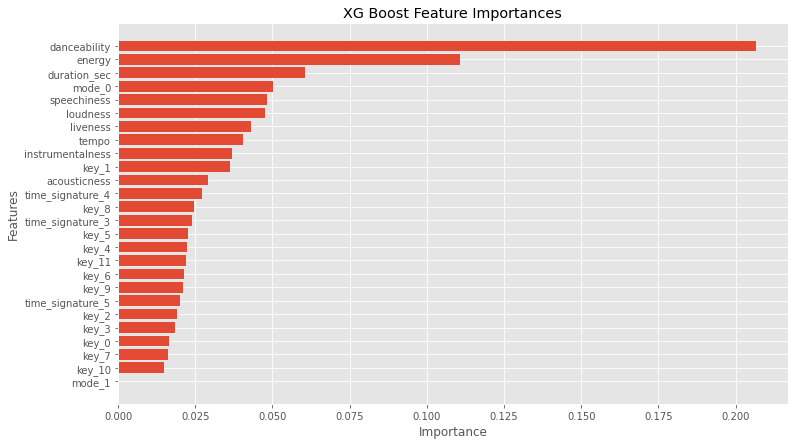

XG Boost Mean Absolute Error (MAE): 0.1390
XG Boost Mean Squared Error (MSE): 0.0305
XG Boost Root Mean Squared Error (RMSE): 0.1745


In [51]:
xgb_mae, xgb_mse, xgb_rmse = evaluate_regressor('XG Boost',xgb_best_model, x_test, y_test)

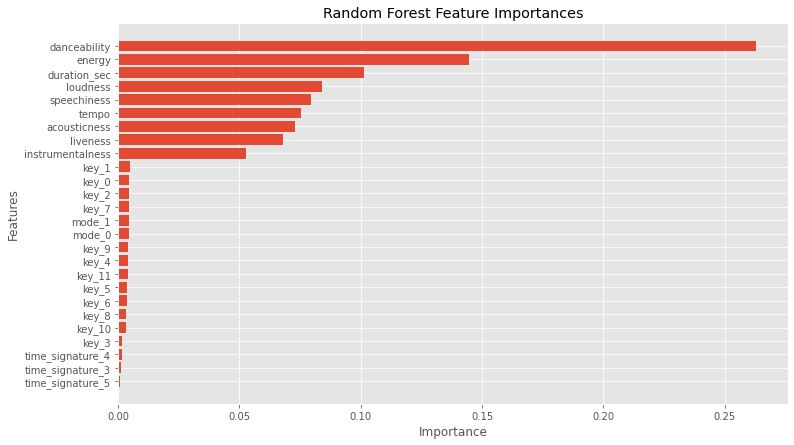

Random Forest Mean Absolute Error (MAE): 0.1341
Random Forest Mean Squared Error (MSE): 0.0293
Random Forest Root Mean Squared Error (RMSE): 0.1711


In [52]:
rf_mae, rf_mse, rf_rmse = evaluate_regressor('Random Forest',rf_best_model, x_test, y_test)

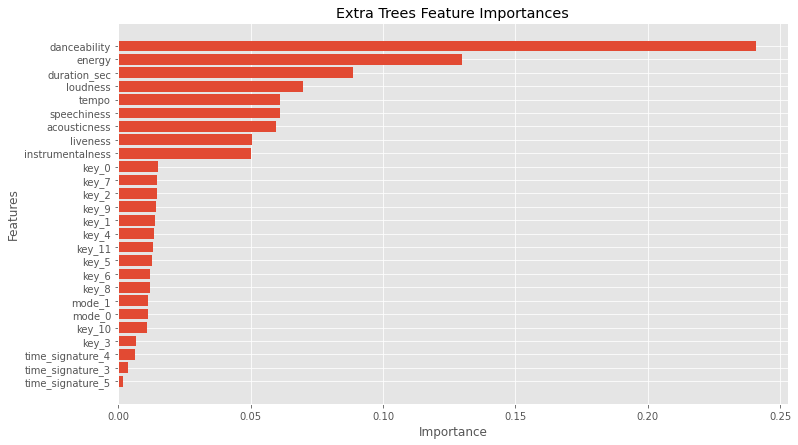

Extra Trees Mean Absolute Error (MAE): 0.1296
Extra Trees Mean Squared Error (MSE): 0.0289
Extra Trees Root Mean Squared Error (RMSE): 0.1700


In [53]:
ex_mae, ex_mse, ex_rmse = evaluate_regressor('Extra Trees',ex_best_model, x_test, y_test)

#### *Best Model* 

- Our best model is an Extra Trees Regressor with the following characteristics

In [59]:
print(f"Best Model: ", ex_best_model)
print(f"Best MAE: ", ex_mae)

Best Model:  ExtraTreesRegressor(n_estimators=500, n_jobs=10, random_state=123)
Best MAE:  0.12963496082835377


### *Evaluation on a new random sample of tracks* 

- We will further evaluate our model on a sample of Spotify's top-streaming charts around the world
- Data for a list of countries and the world as a whole, for the period 2017-2019, are available in the following link
    - https://zenodo.org/record/4778563

##### *Import data downloaded from Zenodo*

In [29]:
# Initialize variables
header = 0  # Header is in the first row of CSV files
dfs = []    # List to store DataFrames

# Iterate through CSV files in specified directory structure
for file in glob.glob('Charts/*/201?/*.csv'):
    # Extract region and dates from the file path
    region = file.split('\\')[1]
    dates = re.findall('\d{4}-\d{2}-\d{2}', file.split('/')[-1])

    # Read CSV file into a DataFrame and add date-related columns
    weekly_chart = pd.read_csv(file, header=header, sep='\t')
    weekly_chart['week_start'] = datetime.strptime(dates[0], '%Y-%m-%d')
    weekly_chart['week_end'] = datetime.strptime(dates[1], '%Y-%m-%d')
    weekly_chart['region'] = region

    # Append the DataFrame to the list
    dfs.append(weekly_chart)

# Concatenate all DataFrames into a single DataFrame
all_charts = pd.concat(dfs)
all_charts.head()

,position,song_id,song_name,artist,streams,last_week_position,weeks_on_chart,peak_position,position_status,week_start,week_end,region
0,1,5aAx2yezTd8zXrkmtKl66Z,Starboy,The Weeknd,947261,NaN,1,1,new,2016-12-30,2017-01-06,au
1,2,5knuzwU65gJK7IF5yJsuaW,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,893107,NaN,1,2,new,2016-12-30,2017-01-06,au
2,3,7BKLCZ1jbUBVqRi2FVlTVw,Closer,The Chainsmokers,871617,NaN,1,3,new,2016-12-30,2017-01-06,au
3,4,3NdDpSvN911VPGivFlV5d0,I Don’t Wanna Live Forever (Fifty Shades Darke...,ZAYN,791592,NaN,1,4,new,2016-12-30,2017-01-06,au
4,5,78rIJddV4X0HkNAInEcYde,Call On Me - Ryan Riback Extended Remix,Starley,743490,NaN,1,5,new,2016-12-30,2017-01-06,au


##### *Get a random sample of 2000 tracks*

- We get a random sample of 2000 song IDs
- We the proceed to download their features from the Spotify Web API

In [34]:
random_ids = all_charts.song_id.sample(n=2000, random_state=13)

In [36]:
# set starting time
start_time = datetime.now()

# download audio features
sample_tracks = get_audio_features_with_ids(random_ids,sp)

# set ending time
end_time = datetime.now()

print(f'Elapsed time: {end_time - start_time}')

Getting audio features...
Getting audio features... Done!

Elapsed time: 0:03:58.237382


##### *Apply the same transformations as previously*

In [111]:
test_sample_tracks = sample_tracks.copy()

In [112]:
# Get categorical columns except for song id
cat_col = test_sample_tracks.drop(columns=['song_id']).select_dtypes(include=['object'])
    
# Convert categorical columns to numeric
if len(cat_col) > 0:
    for col in cat_col:
        test_sample_tracks[col] = pd.to_numeric(test_sample_tracks[col])
    
#unit conversion
test_sample_tracks['duration_ms'] = test_sample_tracks['duration_ms'] / 1000

# rename column
test_sample_tracks = test_sample_tracks.rename(columns={'duration_ms':'duration_sec'})

# Create a list of indexes to drop
indexes_to_drop = list(test_sample_tracks[test_sample_tracks['time_signature'].apply(lambda x: x not in range(3, 8))].index)

# Use the drop method to remove the rows with the specified indexes
test_sample_tracks.drop(indexes_to_drop, inplace=True)

# get dummy variables
test_sample_tracks = pd.get_dummies(test_sample_tracks, columns=['key', 'mode', 'time_signature'], drop_first=False)

#keep valid songs
test_sample_tracks = test_sample_tracks[(test_sample_tracks.duration_sec > 60) & (test_sample_tracks.duration_sec < 600)]

# drop unwanted columns
test_sample_tracks = test_sample_tracks.drop(columns=['song_id'])

##### *Function to load and process the training set*

- As a training set we are going to use the initial dataset as a whole

In [116]:
def load_train_data(df):
    
    # Drop unwanted columns
    df.drop(columns=['song_name', 'artist', 'playlist'], inplace=True)
    
    # Drop duplicate IDs
    df.drop_duplicates(subset=['song_id'], inplace=True, ignore_index=True)
    
    # Convert duration from milliseconds to seconds
    df.duration_ms = df.duration_ms / 1000
    
    # Rename duration column
    df.rename(columns={'duration_ms':'duration_sec'}, inplace=True)
    
    # Create a list of indexes to drop
    indexes_to_drop = list(df[df['time_signature'].apply(lambda x: x not in range(3, 8))].index)
    
    # Drop rows with invalid time signature values
    df.drop(labels=indexes_to_drop, inplace=True)
    
    # Reset index
    df.reset_index(inplace=True, drop=True)
    
    # Get dummy variables
    df = pd.get_dummies(df, columns=['key', 'mode', 'time_signature'], drop_first=False)
    
    # Keep tracks with 1min < duration < 10min
    df = df[(df.duration_sec > 60) & (df.duration_sec < 600)]
    
    return df

In [117]:
# features to scale
for_scaling = ['duration_sec', 'loudness', 'tempo']

# initialise scaler
minmax = MinMaxScaler()

#define train and test set
train_set = load_train_data(spotify_df.copy())
test_set = test_sample_tracks

# scale train and test set
train_set[for_scaling] = minmax.fit_transform(train_set[for_scaling])
test_set[for_scaling] = minmax.transform(test_set[for_scaling])

##### *Best model performance on the test set*

In [118]:
# define features and target variable
random_x = test_set.drop(columns=['valence'])
random_y = test_sample_tracks.valence

In [119]:
# initialise model
model = ExtraTreesRegressor(n_estimators=500,min_samples_split = 2,max_depth = None, random_state=123, n_jobs = 10)

# fit the model
model.fit(train_set.drop(columns=['song_id', 'valence']), train_set.valence)

ExtraTreesRegressor(n_estimators=500, n_jobs=10, random_state=123)

In [120]:
# Perform predictions on the test set
random_y_pred = model.predict(random_x)

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(random_y, random_y_pred)
mse = mean_squared_error(random_y, random_y_pred)
rmse = np.sqrt(mse)

# Print and return evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Absolute Error (MAE): 0.0566
Mean Squared Error (MSE): 0.0125
Root Mean Squared Error (RMSE): 0.1119


#### *Conclusion*

- Valence Prediction
    - As we can see our tuned Extra Trees Model gives a MAE of **0.0566**
    - This further validates the fact that it is our best performing model
- Features Influencing Valence
    - According to all our models the features that seem to influence valence the most are **danceability** and **energy**.
    - This makes a lot of sense since dancing and energy increase do actually make us happier